In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
Image_size = 256
Batch_size = 32
channels = 3
epoch = 5

In [3]:
data = tf.keras.preprocessing.image_dataset_from_directory(
    'PlantVillage',
    shuffle = True,
    image_size = (Image_size, Image_size),
    batch_size = Batch_size
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = data.class_names

In [5]:
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(data)

68

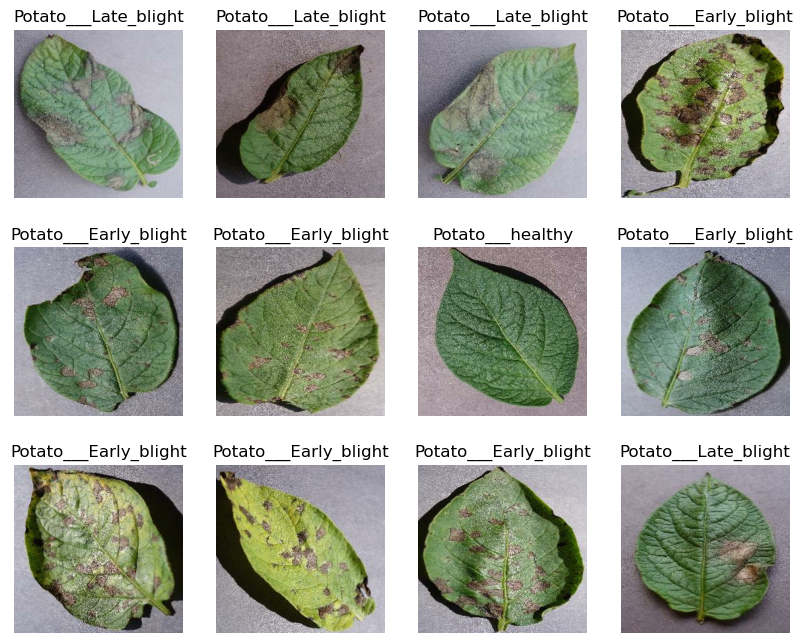

In [7]:
plt.figure(figsize=(10,8))
for image,label in data.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(class_names[label[i]])
        plt.axis('off')

In [8]:
# test smaple size ==> train = 80%, validation = 10%, test = 10%
train_size = 0.8
len(data)*train_size

54.400000000000006

In [9]:
train_d = data.take(54)

In [10]:
t = data.skip(54)
len(t)

14

In [11]:
val_d = t.take(7)

In [12]:
test_d = t.skip(7)

In [13]:
def split_data(data, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    d_size = len(data)
    if shuffle:
        data = data.shuffle(shuffle_size, seed=12)
    train_size = int(train_split*d_size)
    val_size = int(val_split*d_size)

    train_d = data.take(train_size)
    val_d = data.skip(train_size).take(val_size)
    test_d = data.skip(train_size).skip(val_size)

    return train_d, val_d, test_d

In [14]:
train_d, val_d, test_d = split_data(data)

In [15]:
train_d = train_d.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_d = val_d.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_d = test_d.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)


In [16]:
resize_rescale = tf.keras.Sequential([
    layers.Resizing(Image_size, Image_size),
    layers.Rescaling(1.0/255)  # It should be 1.0/255 to normalize pixel values to [0, 1]
])

In [17]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2),
])

In [18]:
input_shape = (Image_size, Image_size, channels)
n_classes = 3
model = models.Sequential([
    layers.Input(shape=input_shape),  # Specify input shape without batch size
    resize_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         147,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 277,891 (1.06 MB)

 Trainable params: 277,891 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [20]:
hist = model.fit(
    train_d,
    epochs = epoch,
    batch_size = Batch_size,
    verbose = 1,
    validation_data = val_d
)

Epoch 1/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.5516 - loss: 0.8920 - val_accuracy: 0.7083 - val_loss: 0.6795
Epoch 2/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 153s 3s/step - accuracy: 0.7663 - loss: 0.5760 - val_accuracy: 0.8177 - val_loss: 0.5199
Epoch 3/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - accuracy: 0.8536 - loss: 0.3802 - val_accuracy: 0.8750 - val_loss: 0.3488
Epoch 4/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 145s 3s/step - accuracy: 0.8924 - loss: 0.2750 - val_accuracy: 0.9010 - val_loss: 0.2551
Epoch 5/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 158s 3s/step - accuracy: 0.9235 - loss: 0.2032 - val_accuracy: 0.6458 - val_loss: 0.9395


In [21]:
sc = model.evaluate(test_d)

8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 617ms/step - accuracy: 0.5853 - loss: 1.2983


In [22]:
sc

[1.1344773769378662, 0.6328125]

In [23]:
hist.params

{'verbose': 1, 'epochs': 5, 'steps': 54}

In [24]:
hist.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [25]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

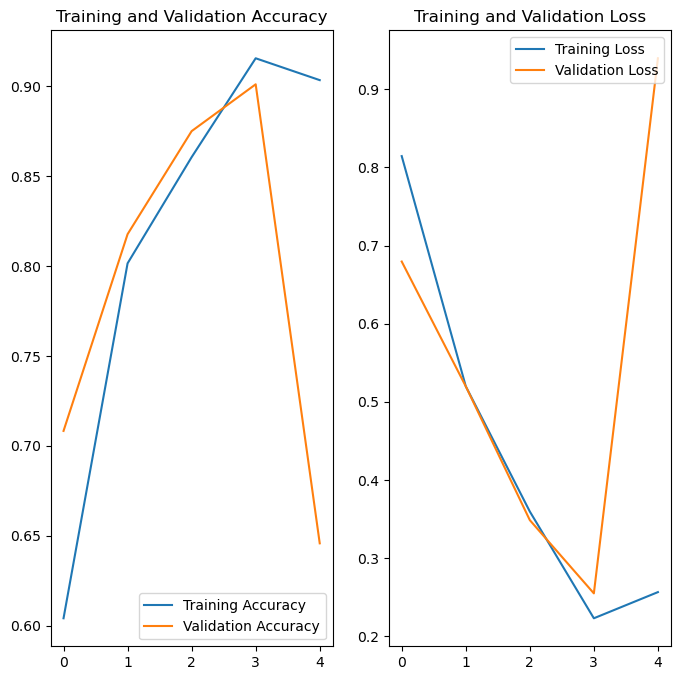

In [26]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(epoch), acc, label='Training Accuracy')
plt.plot(range(epoch), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epoch), loss, label='Training Loss')
plt.plot(range(epoch), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Actual Class : Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Class : Potato___Late_blight


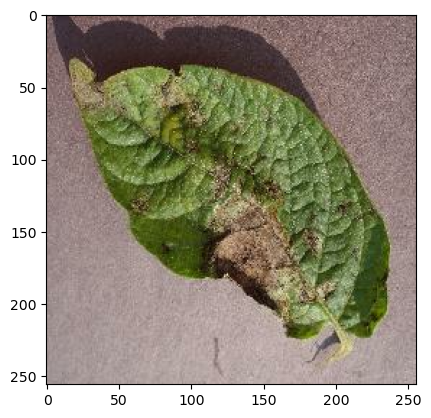

In [27]:
import numpy as np
for image, label in test_d.take(1):
    img = image[0].numpy().astype('uint8')
    act_lable = label[0].numpy()
    plt.imshow(img)
    print("Actual Class :",class_names[act_lable])

    pred_label = model.predict(image)
    print("Predicted Class :",class_names[np.argmax(pred_label[0])])


In [28]:
def predict(model, img):
    img_arr = tf.keras.preprocessing.image.img_to_array(image[i].numpy())
    img_arr = tf.expand_dims(img_arr, 0)

    predictions = model.predict(img_arr)

    pred_class = class_names[np.argmax(predictions[0])]
    confidence = round(100* (np.max(predictions[0])),2)
    return pred_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


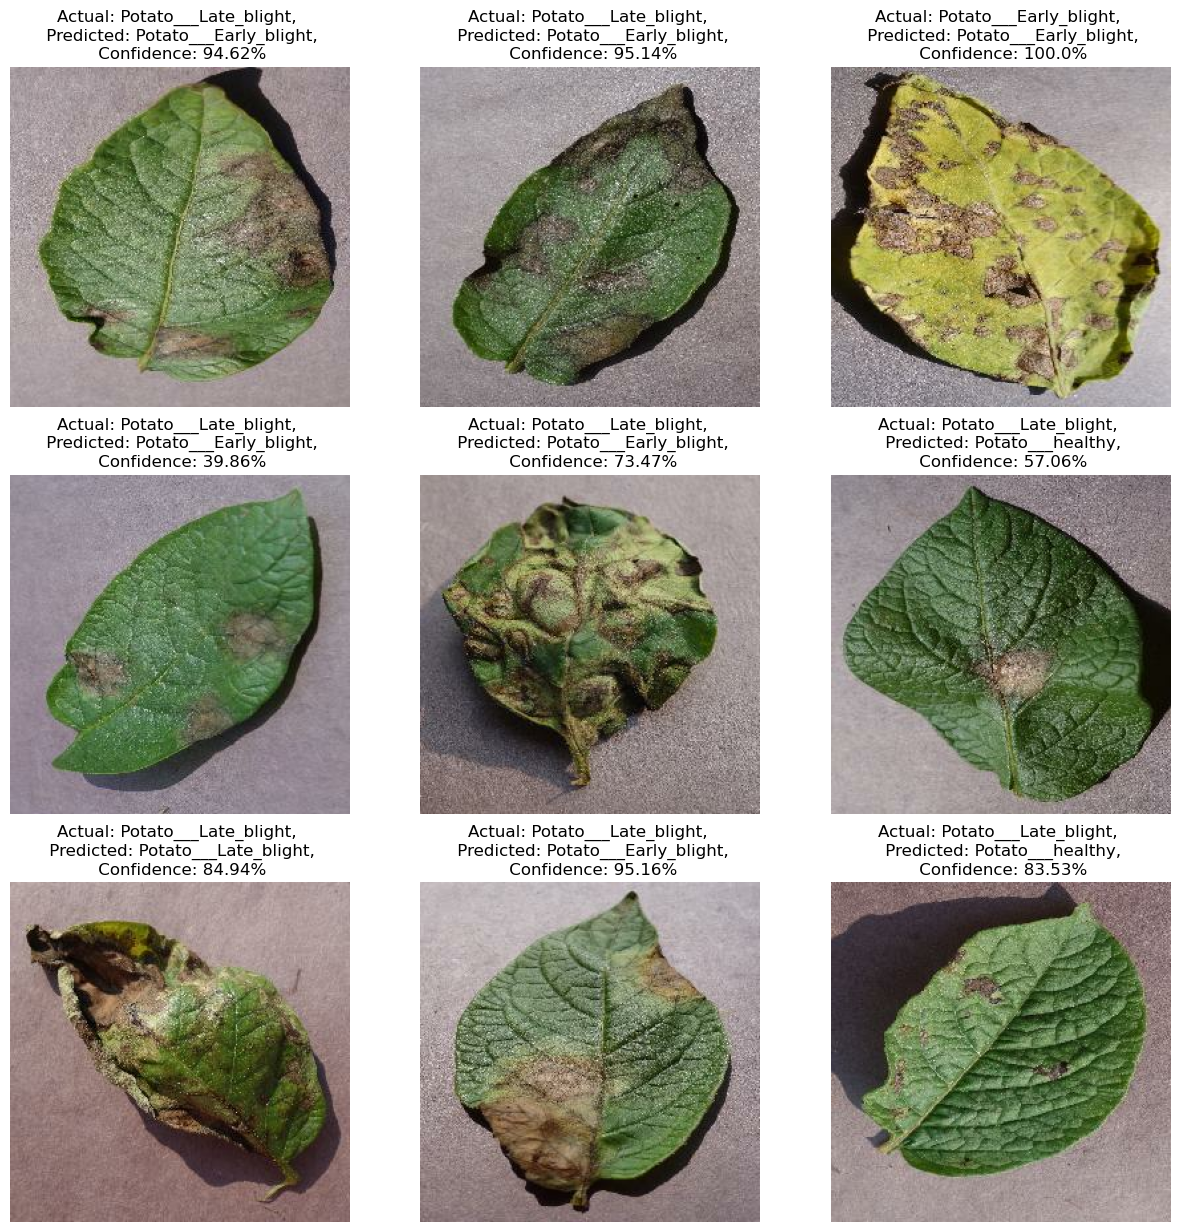

In [29]:
plt.figure(figsize = (15,15))
for image, label in test_d.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        img = image[i].numpy().astype('uint8')
        plt.imshow(img)
        act_lable = class_names[label[i].numpy()]
        pred, conf = predict(model, image[i].numpy())

        plt.title(f'Actual: {act_lable}, \n Predicted: {pred},\n Confidence: {conf}%')
        plt.axis('off')

In [30]:
import os
from tensorflow.keras.models import load_model

# Define the path to the models directory
path = r'C:\Users\eshwar reddy\ML_PROJECTS\DeepLearningProjects\potatodiseaseDLP\models'

# Determine the next model version
model_version = max([int(i.split('.')[0]) for i in os.listdir(path) if i.split('.')[-1] in ['keras', 'h5']] + [0]) + 1

# Save the model with the .keras extension
model.save(os.path.join(path, f"{model_version}.keras"))
